# Proyecto 1 - Minería de Datos

## Carga de Librerías


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor


# Configuración de estilo para visualización


In [2]:
#sns.set_style("whitegrid")
train_df = pd.read_csv("train.csv")

## Carga de Datos


In [3]:
print("Información general del dataset:")
train_df.info()

print("\nResumen estadístico:")
print(train_df.describe())

Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460

## Análisis de Valores Nulos


In [4]:
missing_values = train_df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
print("\nValores nulos por columna:")
print(missing_values)


Valores nulos por columna:
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


## Tratamiento de Valores Nulos


In [5]:
# Llenar valores nulos en variables categóricas con "None"
categorical_features = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu",
                        "GarageType", "GarageFinish", "GarageQual", "GarageCond",
                        "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]
# Llenar valores nulos en variables categóricas con "None"
train_df[categorical_features] = train_df[categorical_features].fillna("None")

numerical_features = ["LotFrontage", "GarageYrBlt", "MasVnrArea"]

# Llenar valores nulos en variables numéricas con la mediana
train_df[numerical_features] = train_df[numerical_features].apply(lambda x: x.fillna(x.median()))
    


## Transformación de Datos

In [6]:
# Aplicar logaritmo al precio de venta para normalizar
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])

# Convertir variables categóricas en numéricas con Label Encoding de forma vectorizada
label_encoders = {col: LabelEncoder().fit(train_df[col]) for col in categorical_features}
train_df[categorical_features] = train_df[categorical_features].apply(lambda col: label_encoders[col.name].transform(col))


## Análisis de Correlación


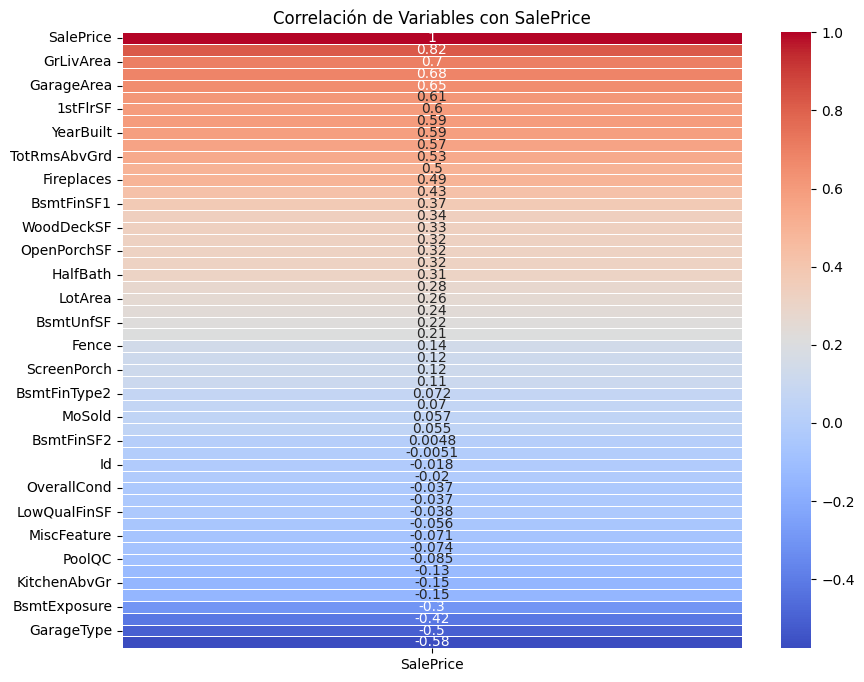

In [7]:
plt.figure(figsize=(10, 8))
corr_matrix = train_df.corr(numeric_only=True)
sns.heatmap(corr_matrix[['SalePrice']].sort_values(by='SalePrice', ascending=False), 
            annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlación de Variables con SalePrice")
plt.show()

In [8]:
correlation_threshold = 0.5
strong_corr_vars = corr_matrix["SalePrice"].abs().sort_values(ascending=False)
strong_corr_vars = strong_corr_vars[strong_corr_vars > correlation_threshold]
print("Variables con mayor correlación con SalePrice:")
print(strong_corr_vars)

Variables con mayor correlación con SalePrice:
SalePrice       1.000000
OverallQual     0.817185
GrLivArea       0.700927
GarageCars      0.680625
GarageArea      0.650888
TotalBsmtSF     0.612134
1stFlrSF        0.596981
FullBath        0.594771
YearBuilt       0.586570
BsmtQual        0.576969
YearRemodAdd    0.565608
TotRmsAbvGrd    0.534422
GarageType      0.503129
Name: SalePrice, dtype: float64


## Análisis de Clustering (K-Means y DBSCAN)


   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

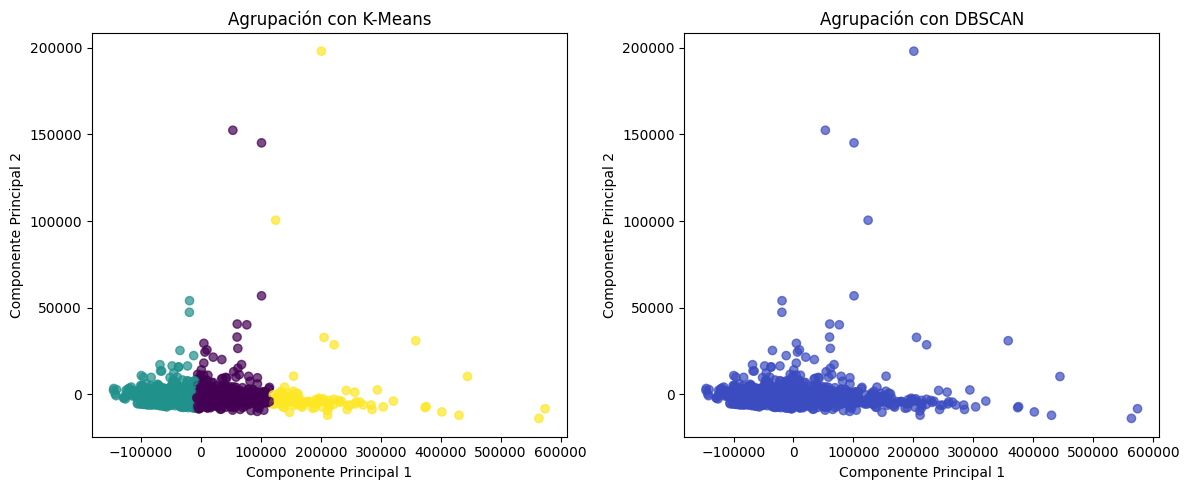

In [9]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt


# Carga del dataset
df = pd.read_csv("train.csv")  # Asegúrate de que el archivo "train.csv" está en la misma carpeta
print(df.head())  # Muestra las primeras filas para verificar que los datos están cargados


# Seleccionar variables relevantes para el clustering
features_for_clustering = df[['LotArea', 'GrLivArea', 'SalePrice']]

# Aplicar PCA para reducir la dimensionalidad y visualizar los datos
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_for_clustering)

# Aplicar K-Means con 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters_kmeans = kmeans.fit_predict(features_pca)

# Aplicar DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters_dbscan = dbscan.fit_predict(features_pca)

# Visualización de Clustering con K-Means
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=clusters_kmeans, cmap='viridis', alpha=0.7)
plt.title('Agrupación con K-Means')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

# Visualización de Clustering con DBSCAN
plt.subplot(1, 2, 2)
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=clusters_dbscan, cmap='coolwarm', alpha=0.7)
plt.title('Agrupación con DBSCAN')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

plt.tight_layout()
plt.show()


## División de Datos en Entrenamiento y Prueba


In [10]:
X = train_df.drop(columns=["SalePrice", "Id"])
y = train_df["SalePrice"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Tamaño de los conjuntos de datos:")
print(f"Entrenamiento: {X_train.shape}, Prueba: {X_test.shape}")



Tamaño de los conjuntos de datos:
Entrenamiento: (1168, 79), Prueba: (292, 79)


In [11]:
categorical_features = X_train.select_dtypes(include=['object']).columns

column_transformer = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)],
    remainder='passthrough' 
)

X_train_transformed = column_transformer.fit_transform(X_train)
X_test_transformed = column_transformer.transform(X_test)

print("Preprocesamiento completado")

Preprocesamiento completado


# Análisis de relaciones con la variable respuesta

### Análisis de Relación con Gráficos de Dispersión

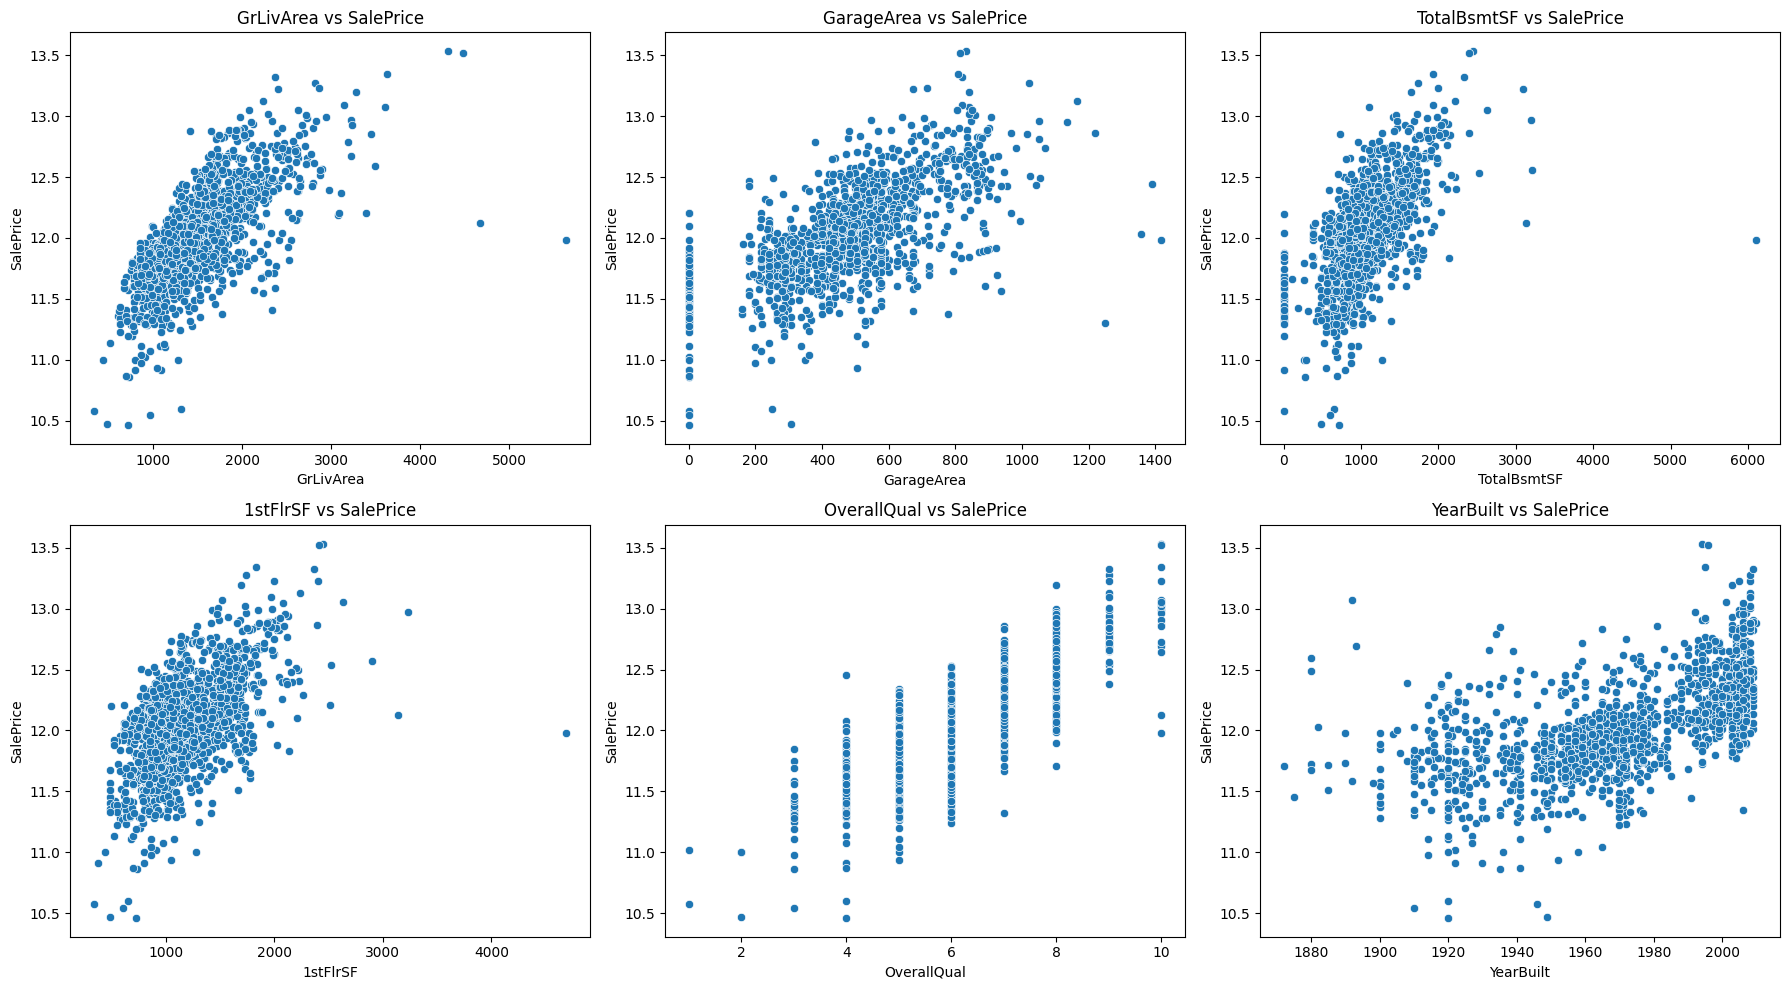

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()  # Convierte la matriz de ejes en una lista

top_vars = ["GrLivArea", "GarageArea", "TotalBsmtSF", "1stFlrSF", "OverallQual", "YearBuilt"]

for var, ax in zip(top_vars, axes):
    sns.scatterplot(x=train_df[var], y=train_df["SalePrice"], ax=ax)
    ax.set_title(f"{var} vs SalePrice")

plt.tight_layout()
plt.show()


### Análisis de Relación con Boxplots

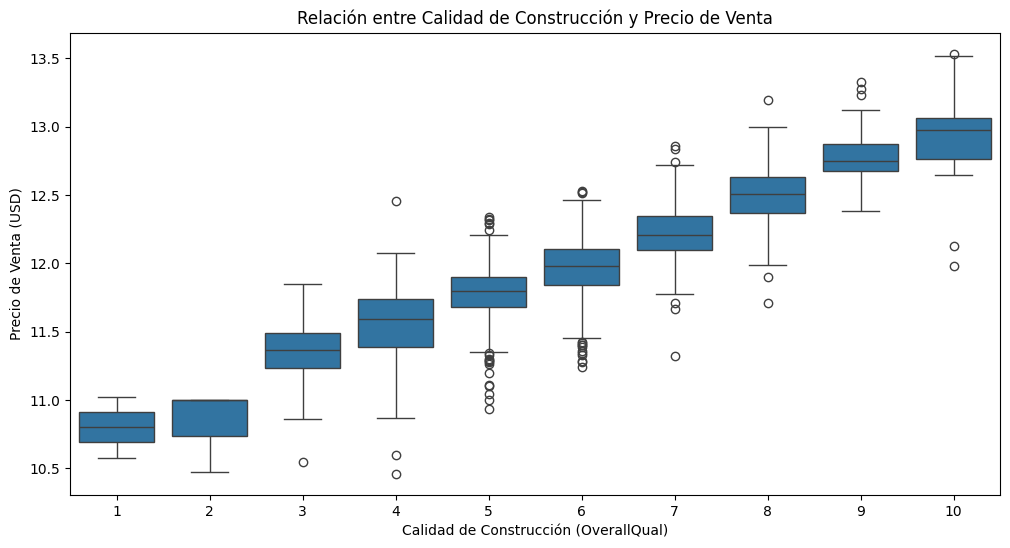

In [13]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=train_df["OverallQual"], y=train_df["SalePrice"])
plt.xlabel("Calidad de Construcción (OverallQual)")
plt.ylabel("Precio de Venta (USD)")
plt.title("Relación entre Calidad de Construcción y Precio de Venta")
plt.show()

### Regresión Lineal para evaluar impacto de variables

In [14]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

# Separar variables numéricas y categóricas
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Preprocesador: Escalar numéricas y transformar categóricas
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

# Crear pipeline con preprocesamiento y regresión lineal
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regression", LinearRegression())
])

# Entrenar modelo
pipeline.fit(X, y)

# Obtener coeficientes de regresión
feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()
coef_dict = dict(zip(feature_names, pipeline.named_steps["regression"].coef_))

# Imprimir coeficientes
print("\nCoeficientes de la regresión lineal:")
for var, coef in coef_dict.items():
    print(f"{var}: {coef:.2f}")



Coeficientes de la regresión lineal:
num__MSSubClass: -0.02
num__LotFrontage: 0.01
num__LotArea: 0.03
num__Alley: 0.00
num__OverallQual: 0.06
num__OverallCond: 0.04
num__YearBuilt: 0.05
num__YearRemodAdd: 0.02
num__MasVnrArea: 0.00
num__BsmtQual: -0.01
num__BsmtCond: 0.00
num__BsmtExposure: -0.01
num__BsmtFinType1: -0.00
num__BsmtFinSF1: 0.03
num__BsmtFinType2: 0.00
num__BsmtFinSF2: 0.01
num__BsmtUnfSF: -0.00
num__TotalBsmtSF: 0.03
num__1stFlrSF: 0.04
num__2ndFlrSF: 0.04
num__LowQualFinSF: 0.01
num__GrLivArea: 0.07
num__BsmtFullBath: 0.02
num__BsmtHalfBath: 0.00
num__FullBath: 0.01
num__HalfBath: 0.01
num__BedroomAbvGr: 0.00
num__KitchenAbvGr: -0.01
num__TotRmsAbvGrd: 0.01
num__Fireplaces: 0.01
num__FireplaceQu: 0.00
num__GarageType: -0.00
num__GarageYrBlt: -0.01
num__GarageFinish: -0.00
num__GarageCars: 0.01
num__GarageArea: 0.03
num__GarageQual: 0.00
num__GarageCond: 0.00
num__WoodDeckSF: 0.01
num__OpenPorchSF: 0.00
num__EnclosedPorch: 0.01
num__3SsnPorch: 0.00
num__ScreenPorch: 0.0

### Árbol de Decisión para relaciones no lineales

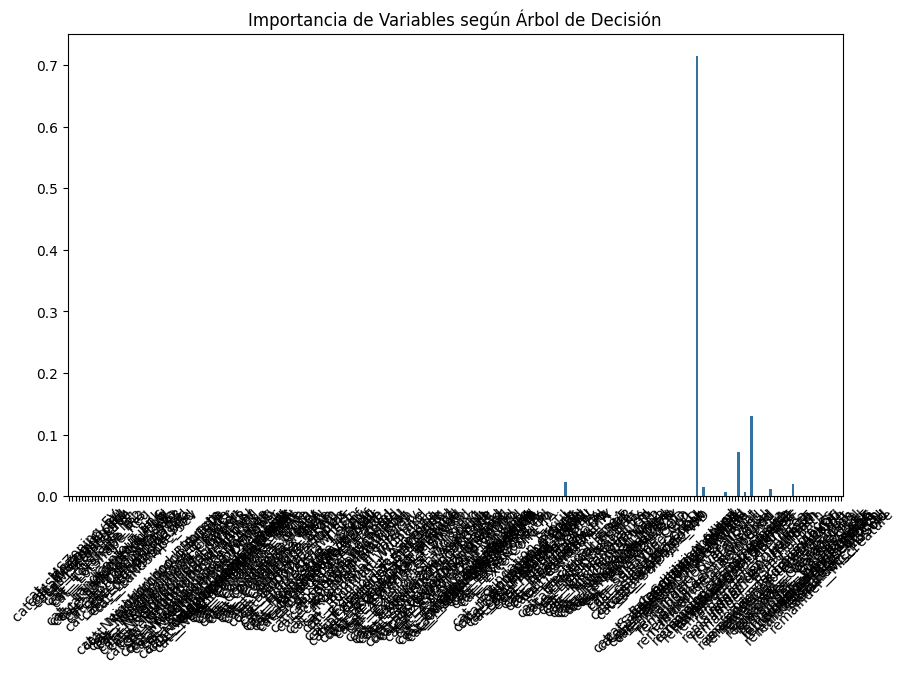

In [15]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns

# Separar variables numéricas y categóricas
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Aplicar OneHotEncoder a las variables categóricas
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
], remainder="passthrough")  # Mantener las variables numéricas sin cambios

# Transformar X para que todas las variables sean numéricas
X_transformed = preprocessor.fit_transform(X)

# Entrenar el Árbol de Decisión con las variables transformadas
tree = DecisionTreeRegressor(max_depth=4, random_state=42)
tree.fit(X_transformed, y)

# Obtener nombres de las variables después del OneHotEncoder
feature_names = preprocessor.get_feature_names_out()

# Visualizar la importancia de las características
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_names, y=tree.feature_importances_)
plt.xticks(rotation=45)
plt.title("Importancia de Variables según Árbol de Decisión")
plt.show()


In [16]:

# Importar librerías necesarias
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Cargar el dataset
train_df = pd.read_csv("train.csv")

# Rellenar valores nulos en variables numéricas con la mediana
numerical_features = train_df.select_dtypes(include=[np.number]).columns.tolist()
train_df[numerical_features] = train_df[numerical_features].fillna(train_df[numerical_features].median())

# Excluir la variable objetivo "SalePrice" del análisis de VIF
numerical_features.remove("SalePrice")

# Calcular el Variance Inflation Factor (VIF) para cada variable numérica
X = train_df[numerical_features]
X = sm.add_constant(X)  # Agregar constante para el modelo

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Mostrar el análisis de multicolinealidad
display(vif_data)

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, train_df["SalePrice"], test_size=0.2, random_state=42)

# Entrenar modelo de regresión lineal
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Predicciones en entrenamiento y prueba
y_train_pred = modelo.predict(X_train)
y_test_pred = modelo.predict(X_test)

# Calcular métricas de error
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Comparación de errores para detectar sobreajuste
error_comparison = pd.DataFrame({
    "Conjunto": ["Entrenamiento", "Prueba"],
    "RMSE": [train_rmse, test_rmse],
    "MAE": [train_mae, test_mae],
    "R²": [train_r2, test_r2]
})

display(error_comparison)

# Evaluación de modelos en el conjunto de prueba
modelo_arbol = DecisionTreeRegressor(random_state=42)
modelo_arbol.fit(X_train, y_train)
y_test_pred_arbol = modelo_arbol.predict(X_test)

# Comparación de modelos
model_comparison = pd.DataFrame({
    "Modelo": ["Regresión Lineal", "Árbol de Decisión"],
    "RMSE": [test_rmse, np.sqrt(mean_squared_error(y_test, y_test_pred_arbol))],
    "MAE": [test_mae, mean_absolute_error(y_test, y_test_pred_arbol)],
    "R²": [test_r2, r2_score(y_test, y_test_pred_arbol)]
})

display(model_comparison)

# Cargar el conjunto de datos de prueba
test_df = pd.read_csv("test.csv")

# Asegurar que todas las columnas de prueba coincidan con las de entrenamiento
X_final_test = test_df[numerical_features].fillna(train_df[numerical_features].median())

# Agregar la constante "const" como en el entrenamiento
X_final_test = sm.add_constant(X_final_test, has_constant="add")

# Realizar la predicción final
test_df["SalePrice_Predicted"] = modelo.predict(X_final_test)

# Guardar el resultado en un archivo CSV
test_df[["Id", "SalePrice_Predicted"]].to_csv("predicciones_finales.csv", index=False)

# Mostrar las primeras filas de las predicciones
display(test_df[["Id", "SalePrice_Predicted"]])



c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Variable,VIF
0,const,2.416497e+06
1,Id,1.026945e+00
2,MSSubClass,1.657272e+00
3,LotFrontage,1.568471e+00
4,LotArea,1.255983e+00
5,OverallQual,3.264369e+00
6,OverallCond,1.596944e+00
7,YearBuilt,5.008877e+00
8,YearRemodAdd,2.425908e+00
9,MasVnrArea,1.394015e+00


,Conjunto,RMSE,MAE,R²
0,Entrenamiento,33907.325191,21073.200082,0.807243
1,Prueba,36879.819322,23000.028866,0.822678


,Modelo,RMSE,MAE,R²
0,Regresión Lineal,36879.819322,23000.028866,0.822678
1,Árbol de Decisión,40272.116165,27587.554795,0.788556


,Id,SalePrice_Predicted
0,1461,114107.857536
1,1462,145821.139603
2,1463,171236.243060
3,1464,196886.739389
4,1465,195832.330468
...,...,...
1454,2915,53318.665620
1455,2916,62473.236437
1456,2917,161277.296022
1457,2918,92344.814687


# Segunda Entrega
### Librerías a utilizar

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### 1. Cargar el conjunto de datos

In [18]:
train_df = pd.read_csv("train.csv")

#### Preprocesamiento 

In [19]:
categorical_features = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu",
                          "GarageType", "GarageFinish", "GarageQual", "GarageCond",
                          "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]

train_df[categorical_features] = train_df[categorical_features].fillna("None")

numerical_features = ["LotFrontage", "GarageYrBlt", "MasVnrArea"]
train_df[numerical_features] = train_df[numerical_features].apply(lambda x: x.fillna(x.median()))

# Transformar el precio de venta con logaritmo para normalizar la distribución
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])

# Convertir variables categóricas a numéricas mediante Label Encoding
label_encoders = {col: LabelEncoder().fit(train_df[col]) for col in categorical_features}
train_df[categorical_features] = train_df[categorical_features].apply(lambda col: label_encoders[col.name].transform(col))


### 2. Separar el conjunto de datos en entrenamiento y prueba.

In [20]:
# Definimos X eliminando 'Id' y 'SalePrice'
X = train_df.drop(columns=["Id", "SalePrice"])
y = train_df["SalePrice"]

# Convertir todas las variables categóricas a variables dummy
X = pd.get_dummies(X, drop_first=True)

# Separar en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### 3. Árbol de regresión

In [21]:
reg_tree = DecisionTreeRegressor(random_state=42)
reg_tree.fit(X_train, y_train)

# Usar el modelo para predecir en el conjunto de prueba
y_pred = reg_tree.predict(X_test)

# Evaluar el desempeño del modelo
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Desempeño del árbol de regresión:")
print("RMSE:", rmse)
print("R²:", r2)

Desempeño del árbol de regresión:
RMSE: 0.1911380373110358
R²: 0.8042250910123396


### 4.Desarrollen, al menos, 3 modelos más, cambiando el parámetro de la profundidad del árbol.
¿Cuál es el mejor modelo para predecir el precio de las casas?

In [22]:
# Seleccionar las características y la variable objetivo
X = train_df.drop(columns=['SalePrice'])  # Variables predictoras
y = train_df['SalePrice']  # Variable objetivo

# Convertir variables categóricas en numéricas
X = pd.get_dummies(X)

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Actividad 4: Entrenar árboles de regresión con diferentes profundidades
depths = [3, 6, 10]
models = {}
results = {}

for depth in depths:
    model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    models[depth] = model
    results[depth] = {'MAE': mae, 'MSE': mse, 'R2': r2}

# Seleccionar el mejor modelo basado en R2
best_depth = max(results, key=lambda d: results[d]['R2'])
best_model = models[best_depth]

print(f"Mejor profundidad: {best_depth}, R2: {results[best_depth]['R2']}")

Mejor profundidad: 10, R2: 0.7918606416521997


5. Comparen los resultados con el modelo de regresión lineal de la hoja anterior, ¿cuál lo hizo
mejor?

In [23]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)

r2_lin = r2_score(y_test, y_pred_lin)
print(f"R2 de Regresión Lineal: {r2_lin}")
print(f"R2 del Mejor Árbol de Regresión (profundidad={best_depth}): {results[best_depth]['R2']}")

R2 de Regresión Lineal: 0.9131963705233864
R2 del Mejor Árbol de Regresión (profundidad=10): 0.7918606416521997


### 6.Dependiendo del análisis exploratorio elaborado creen una variable respuesta que les permita clasificar las casas en Económicas, Intermedias o Caras. Los límites de estas clases deben tener un fundamento en la distribución de los datos de precios, y estar bien explicados 

Distribución de categorías de precios:
Cara: 497 casas (34.0%)
Económica: 483 casas (33.1%)
Intermedia: 480 casas (32.9%)


C:\Users\user\AppData\Local\Temp\ipykernel_27680\4166350755.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='PriceCategory', y='SalePrice', data=train_df,
C:\Users\user\AppData\Local\Temp\ipykernel_27680\4166350755.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='PriceCategory', data=train_df,


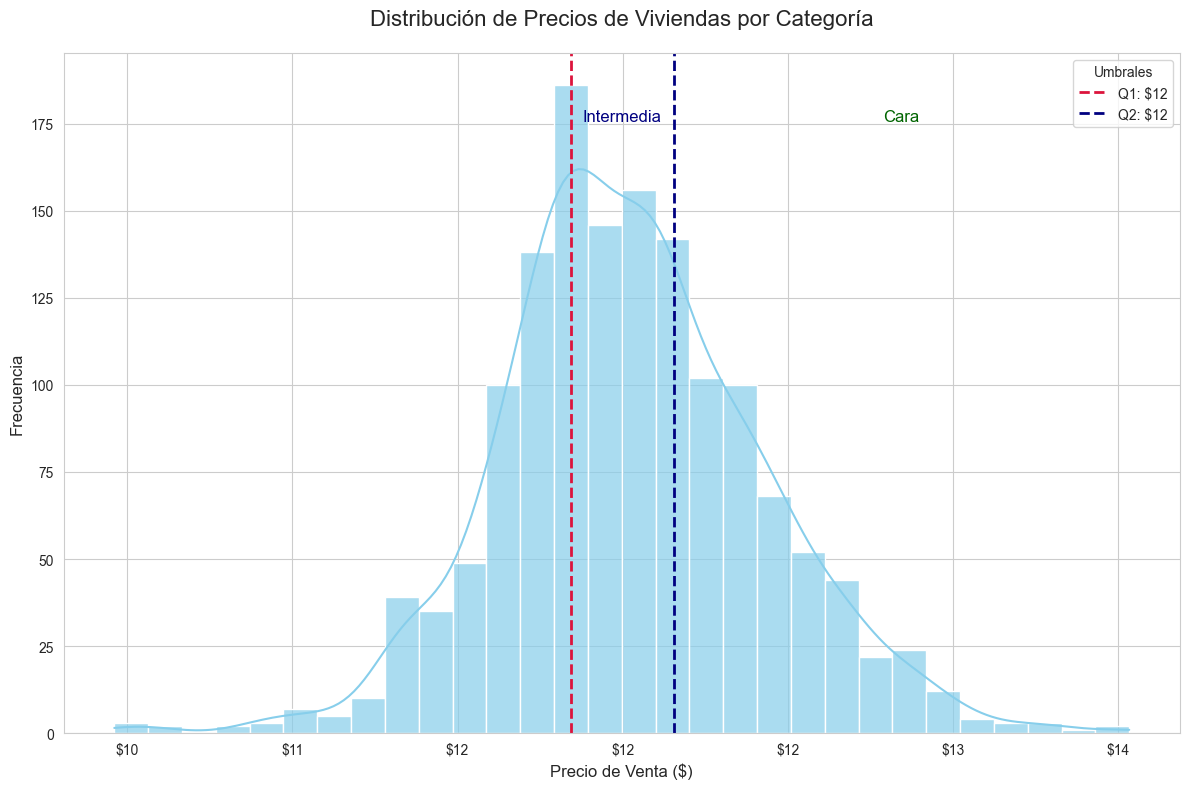

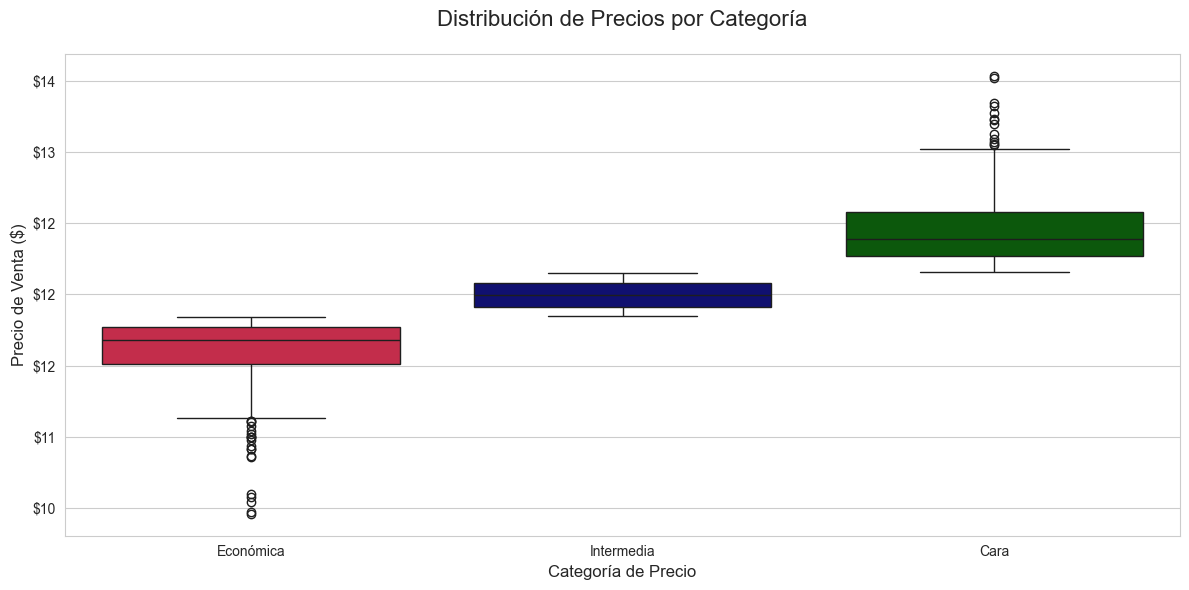

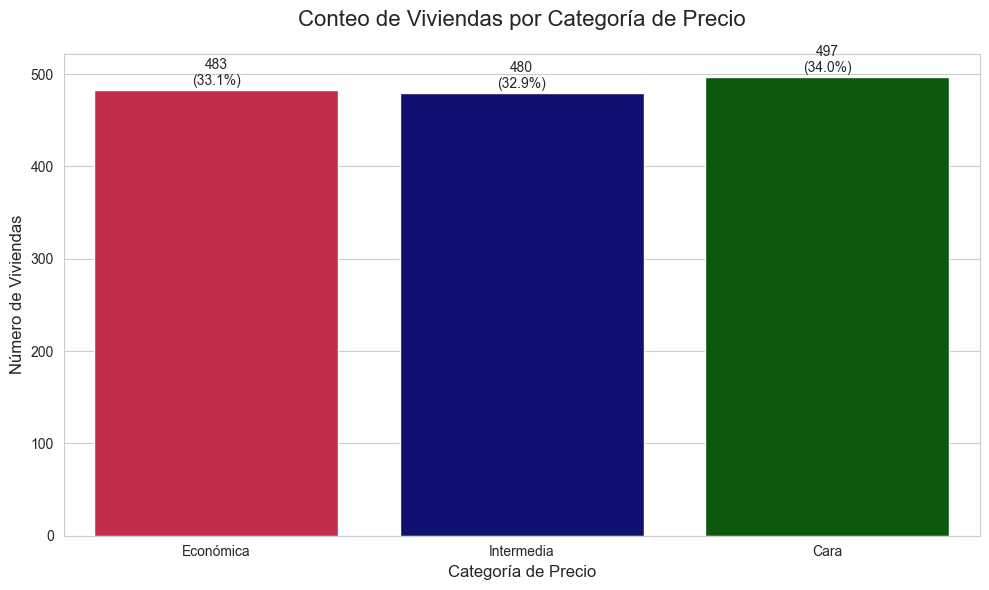

In [24]:
from matplotlib.ticker import FuncFormatter


# Definir cuantiles para categorización
y = train_df['SalePrice']  # Asegúrate de que esta columna existe en tu DataFrame

# Definir cuantiles para categorización (usando numpy para mayor precisión)
q1 = np.percentile(y, 33)
q2 = np.percentile(y, 66)

def categorizar_precio(precio):
    if precio <= q1:
        return 'Económica'
    elif precio <= q2:
        return 'Intermedia'
    else:
        return 'Cara'

# Aplicar categorización
train_df['PriceCategory'] = train_df['SalePrice'].apply(categorizar_precio)

# Mostrar distribución de las categorías con porcentajes
category_counts = train_df['PriceCategory'].value_counts()
total = len(train_df)
print("Distribución de categorías de precios:")
for category, count in category_counts.items():
    percentage = count / total * 100
    print(f"{category}: {count} casas ({percentage:.1f}%)")

# Configurar el estilo de visualización
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Crear una visualización más informativa
# Histograma principal
ax = sns.histplot(train_df['SalePrice'], bins=30, kde=True, alpha=0.7, color='skyblue')

# Añadir líneas de cuantiles más visibles
plt.axvline(q1, color='crimson', linestyle='dashed', linewidth=2, label=f"Q1: ${q1:,.0f}")
plt.axvline(q2, color='navy', linestyle='dashed', linewidth=2, label=f"Q2: ${q2:,.0f}")

# Añadir etiquetas para cada categoría
plt.annotate('Económica', xy=(q1/2, ax.get_ylim()[1]*0.9), 
             ha='center', fontsize=12, color='crimson')
plt.annotate('Intermedia', xy=((q1+q2)/2, ax.get_ylim()[1]*0.9), 
             ha='center', fontsize=12, color='navy')
plt.annotate('Cara', xy=((q2+max(y))/2, ax.get_ylim()[1]*0.9), 
             ha='center', fontsize=12, color='darkgreen')

# Formatear eje X para mostrar precios en formato de moneda
def format_precio(x, pos):
    return f'${x:,.0f}'

ax.xaxis.set_major_formatter(FuncFormatter(format_precio))

# Mejorar la apariencia general
plt.title("Distribución de Precios de Viviendas por Categoría", fontsize=16, pad=20)
plt.xlabel("Precio de Venta ($)", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.legend(title="Umbrales", fontsize=10)
plt.tight_layout()

# Segunda visualización: boxplot por categoría
plt.figure(figsize=(12, 6))
sns.boxplot(x='PriceCategory', y='SalePrice', data=train_df, 
            order=['Económica', 'Intermedia', 'Cara'], 
            palette=['crimson', 'navy', 'darkgreen'])
plt.title("Distribución de Precios por Categoría", fontsize=16, pad=20)
plt.xlabel("Categoría de Precio", fontsize=12)
plt.ylabel("Precio de Venta ($)", fontsize=12)
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_precio))
plt.tight_layout()

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='PriceCategory', data=train_df, 
              order=['Económica', 'Intermedia', 'Cara'],
              palette=['crimson', 'navy', 'darkgreen'])

# Añadir etiquetas con el conteo y porcentaje
for i, p in enumerate(ax.patches):
    height = p.get_height()
    percentage = height / total * 100
    ax.text(p.get_x() + p.get_width()/2., height + 5,
            f'{int(height)}\n({percentage:.1f}%)',
            ha='center', fontsize=10)

plt.title("Conteo de Viviendas por Categoría de Precio", fontsize=16, pad=20)
plt.xlabel("Categoría de Precio", fontsize=12)
plt.ylabel("Número de Viviendas", fontsize=12)
plt.tight_layout()

# Mostrar todos los gráficos
plt.show()

### 7.Elaboren un árbol de clasificación utilizando la variable respuesta que crearon en el punto anterior. Expliquen los resultados a los que llegaron. Muestren el modelo gráficamente. Recuerden que la nueva variable respuesta es categórica, pero se generó a partir de los precios de las casas, no incluyan el precio de venta para entrenar el modelo.

In [25]:
# Importaciones necesarias (al principio del notebook)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from matplotlib.ticker import FuncFormatter
import pydotplus

# Primero, debes cargar los datos
# Asegúrate de tener el archivo CSV o la fuente de datos correcta
# Ejemplo:
# train_df = pd.read_csv('house_prices_train.csv')

# Si no tienes el archivo, proporciona la ruta correcta a tus datos
# Por ejemplo:
# train_df = pd.read_csv('/ruta/a/tu/archivo.csv')

# PARTE 1: Categorización de precios
# Definir cuantiles para categorización
y = train_df['SalePrice']  # Asegúrate de que esta columna existe en tu DataFrame

# Definir cuantiles para categorización (usando numpy para mayor precisión)
q1 = np.percentile(y, 33)
q2 = np.percentile(y, 66)

def categorizar_precio(precio):
    if precio <= q1:
        return 'Económica'
    elif precio <= q2:
        return 'Intermedia'
    else:
        return 'Cara'

# Aplicar categorización
train_df['PriceCategory'] = train_df['SalePrice'].apply(categorizar_precio)

# Mostrar distribución de las categorías con porcentajes
category_counts = train_df['PriceCategory'].value_counts()
total = len(train_df)
print("Distribución de categorías de precios:")
for category, count in category_counts.items():
    percentage = count / total * 100
    print(f"{category}: {count} casas ({percentage:.1f}%)")

# Configurar el estilo de visualización
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Crear una visualización más informativa
# Histograma principal
ax = sns.histplot(train_df['SalePrice'], bins=30, kde=True, alpha=0.7, color='skyblue')

# Añadir líneas de cuantiles más visibles
plt.axvline(q1, color='crimson', linestyle='dashed', linewidth=2, label=f"Q1: ${q1:,.0f}")
plt.axvline(q2, color='navy', linestyle='dashed', linewidth=2, label=f"Q2: ${q2:,.0f}")

# Añadir etiquetas para cada categoría
plt.annotate('Económica', xy=(q1/2, ax.get_ylim()[1]*0.9), 
             ha='center', fontsize=12, color='crimson')
plt.annotate('Intermedia', xy=((q1+q2)/2, ax.get_ylim()[1]*0.9), 
             ha='center', fontsize=12, color='navy')
plt.annotate('Cara', xy=((q2+max(y))/2, ax.get_ylim()[1]*0.9), 
             ha='center', fontsize=12, color='darkgreen')

# Formatear eje X para mostrar precios en formato de moneda
def format_precio(x, pos):
    return f'${x:,.0f}'

ax.xaxis.set_major_formatter(FuncFormatter(format_precio))

# Mejorar la apariencia general
plt.title("Distribución de Precios de Viviendas por Categoría", fontsize=16, pad=20)
plt.xlabel("Precio de Venta ($)", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.legend(title="Umbrales", fontsize=10)
plt.tight_layout()

# Segunda visualización: boxplot por categoría
plt.figure(figsize=(12, 6))
sns.boxplot(x='PriceCategory', y='SalePrice', data=train_df, 
            order=['Económica', 'Intermedia', 'Cara'], 
            palette=['crimson', 'navy', 'darkgreen'])
plt.title("Distribución de Precios por Categoría", fontsize=16, pad=20)
plt.xlabel("Categoría de Precio", fontsize=12)
plt.ylabel("Precio de Venta ($)", fontsize=12)
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_precio))
plt.tight_layout()

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='PriceCategory', data=train_df, 
              order=['Económica', 'Intermedia', 'Cara'],
              palette=['crimson', 'navy', 'darkgreen'])

# Añadir etiquetas con el conteo y porcentaje
for i, p in enumerate(ax.patches):
    height = p.get_height()
    percentage = height / total * 100
    ax.text(p.get_x() + p.get_width()/2., height + 5,
            f'{int(height)}\n({percentage:.1f}%)',
            ha='center', fontsize=10)

plt.title("Conteo de Viviendas por Categoría de Precio", fontsize=16, pad=20)
plt.xlabel("Categoría de Precio", fontsize=12)
plt.ylabel("Número de Viviendas", fontsize=12)
plt.tight_layout()

# Mostrar todos los gráficos
plt.show()

# PARTE 2: Modelo de clasificación
# Convertir etiquetas categóricas a números
label_map = {'Económica': 0, 'Intermedia': 1, 'Cara': 2}
reverse_label_map = {0: 'Económica', 1: 'Intermedia', 2: 'Cara'}
train_df['PriceCategoryNum'] = train_df['PriceCategory'].map(label_map)

# Seleccionar las características y la variable objetivo
X_class = train_df.drop(columns=['SalePrice', 'PriceCategory', 'PriceCategoryNum'])

# Tratamiento mejorado de variables numéricas y categóricas
categorical_cols = X_class.select_dtypes(include=['object', 'category']).columns
numerical_cols = X_class.select_dtypes(include=['int64', 'float64']).columns

# Imputar valores faltantes
for col in numerical_cols:
    X_class[col].fillna(X_class[col].median(), inplace=True)
    
for col in categorical_cols:
    X_class[col].fillna(X_class[col].mode()[0], inplace=True)

# Convertir variables categóricas en numéricas con manejo mejorado
X_class_encoded = pd.get_dummies(X_class, drop_first=True)  # drop_first reduce multicolinealidad

# Variable objetivo
y_class = train_df['PriceCategoryNum']

# Escalado de características numéricas para mejorar rendimiento
scaler = StandardScaler()
X_class_scaled = X_class_encoded.copy()
X_class_scaled[X_class_encoded.columns] = scaler.fit_transform(X_class_encoded)

# Dividir en conjunto de entrenamiento y prueba con estratificación para mantener distribución de clases
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class_scaled, y_class, test_size=0.2, random_state=42, stratify=y_class
)

# Selección de características importantes
selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))
selector.fit(X_train_class, y_train_class)

# Obtener características importantes
selected_features = X_train_class.columns[selector.get_support()]
print(f"Características seleccionadas ({len(selected_features)} de {X_train_class.shape[1]}):")
for i, feature in enumerate(selected_features):
    print(f"{i+1}. {feature}")

# Usar solo las características seleccionadas
X_train_selected = X_train_class[selected_features]
X_test_selected = X_test_class[selected_features]

# Optimización de hiperparámetros con validación cruzada
param_grid = {
    'max_depth': [3, 4, 5, 6, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train_selected, y_train_class)

# Mostrar mejores parámetros
print(f"\nMejores parámetros: {grid_search.best_params_}")
print(f"Mejor precisión en validación cruzada: {grid_search.best_score_:.4f}")

# Obtener el mejor modelo
best_tree = grid_search.best_estimator_

# Evaluar en el conjunto de prueba
y_pred = best_tree.predict(X_test_selected)
accuracy = accuracy_score(y_test_class, y_pred)
print(f"\nPrecisión en conjunto de prueba: {accuracy:.4f}")

# Informe detallado de clasificación
print("\nInforme de clasificación:")
print(classification_report(y_test_class, y_pred, target_names=['Económica', 'Intermedia', 'Cara']))

# Matriz de confusión
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_class, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Crear matriz de confusión visual
ax = sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues', 
                 xticklabels=['Económica', 'Intermedia', 'Cara'],
                 yticklabels=['Económica', 'Intermedia', 'Cara'])
plt.title('Matriz de Confusión', fontsize=15)
plt.ylabel('Etiqueta Real', fontsize=12)
plt.xlabel('Etiqueta Predicha', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Exportar árbol a un archivo temporal para visualización más clara
dot_data = export_graphviz(
    best_tree,
    out_file=None,
    feature_names=selected_features,
    class_names=['Económica', 'Intermedia', 'Cara'],
    filled=True,
    rounded=True,
    special_characters=True,
    max_depth=3  # Limitar profundidad para mejor visualización
)

# Convertir a imagen
graph = pydotplus.graph_from_dot_data(dot_data)

# Colores personalizados para las clases
colors = ['#FF9999', '#99CCFF', '#99FF99']
nodes = graph.get_node_list()

for node in nodes:
    if node.get_name() not in ('node', 'edge'):
        attrs = node.get_attributes()
        if 'label' in attrs:
            values = attrs['label'].split('<br/>')
            for i, clazz in enumerate(['Económica', 'Intermedia', 'Cara']):
                if values and clazz in values[0]:
                    node.set_fillcolor(colors[i])

# Guardar y mostrar el árbol
graph.write_png('best_tree.png')

# Mostrar importancia de características
plt.figure(figsize=(12, 8))
importances = best_tree.feature_importances_
indices = np.argsort(importances)[-15:]  # Top 15 características

plt.barh(range(len(indices)), importances[indices], color='skyblue')
plt.yticks(range(len(indices)), [selected_features[i] for i in indices])
plt.xlabel('Importancia Relativa')
plt.title('Top 15 Características Importantes')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Validación cruzada para evaluar estabilidad del modelo
cv_scores = cross_val_score(best_tree, X_class_scaled[selected_features], y_class, cv=5, scoring='accuracy')
print(f"\nPrecisión en validación cruzada: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Visualización del árbol completo (opcional si es demasiado grande)
plt.figure(figsize=(20, 15))
plot_tree(best_tree, filled=True, feature_names=list(selected_features), 
          class_names=['Económica', 'Intermedia', 'Cara'], fontsize=10)
plt.title("Árbol de Clasificación Óptimo para Categorías de Precios", fontsize=18)
plt.tight_layout()
plt.savefig('decision_tree_full.png', dpi=300, bbox_inches='tight')
plt.show()

# Predicciones en nuevos datos (ejemplo)
print("\nEjemplo de predicción:")
# Tomar 5 muestras aleatorias del conjunto de prueba
sample_indices = np.random.choice(X_test_selected.index, 5, replace=False)
X_samples = X_test_class.loc[sample_indices, selected_features]
y_samples_true = y_test_class.loc[sample_indices]
y_samples_pred = best_tree.predict(X_samples)

# Mostrar resultados
results_df = pd.DataFrame({
    'Predicción': [reverse_label_map[pred] for pred in y_samples_pred],
    'Valor Real': [reverse_label_map[true] for true in y_samples_true],
    'Coincide': y_samples_pred == y_samples_true
})
print(results_df)

# Mostrar probabilidades de predicción
y_probs = best_tree.predict_proba(X_test_selected)
probs_df = pd.DataFrame(y_probs, columns=['Prob. Económica', 'Prob. Intermedia', 'Prob. Cara'])
print("\nProbabilidades de las primeras 5 predicciones:")
print(probs_df.head())

ModuleNotFoundError: No module named 'pydotplus'

### 8. Utilicen el modelo con el conjunto de prueba y determinen la eficiencia del algoritmo para clasificar.

In [ ]:
y_pred_class = clf.predict(X_test_class)
accuracy = accuracy_score(y_test_class, y_pred_class)

print(f"Exactitud del Árbol de Clasificación: {accuracy:.4f}")

Exactitud del Árbol de Clasificación: 0.8048


### 9.Realicen un análisis de la eficiencia del algoritmo usando una matriz de confusión para el árbol de clasificación. Tengan en cuenta la efectividad, dónde el algoritmo se equivocó más, dónde se equivocó menos y la importancia que tienen los errores.

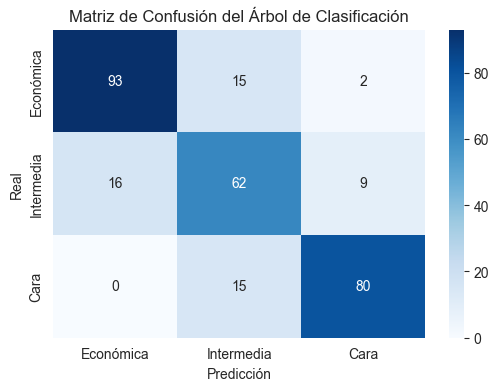


Reporte de Clasificación:
               precision    recall  f1-score   support

   Económica       0.85      0.85      0.85       110
  Intermedia       0.67      0.71      0.69        87
        Cara       0.88      0.84      0.86        95

    accuracy                           0.80       292
   macro avg       0.80      0.80      0.80       292
weighted avg       0.81      0.80      0.81       292



In [ ]:
conf_matrix = confusion_matrix(y_test_class, y_pred_class)

# Mostrar matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Económica', 'Intermedia', 'Cara'], 
            yticklabels=['Económica', 'Intermedia', 'Cara'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión del Árbol de Clasificación")
plt.show()

# Mostrar reporte de clasificación
print("\nReporte de Clasificación:\n", classification_report(y_test_class, y_pred_class, target_names=['Económica', 'Intermedia', 'Cara']))

### 10.Entrenen un modelo usando validación cruzada, predigan con él. ¿le fue mejor que al modelo anterior?

Primeras filas del dataset:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SaleP

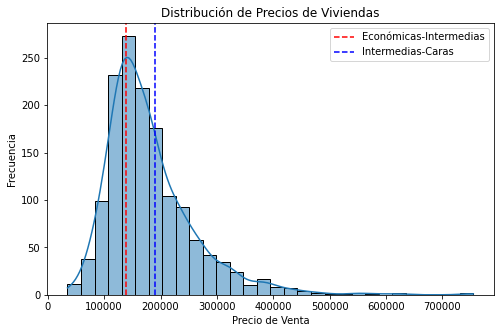

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

csv_path = "train.csv"  
train_df = pd.read_csv(csv_path)

print("Primeras filas del dataset:")
print(train_df.head())

q1 = train_df['SalePrice'].quantile(0.33)
q2 = train_df['SalePrice'].quantile(0.66)

def categorizar_precio(precio):
    if precio <= q1:
        return 'Económica'
    elif precio <= q2:
        return 'Intermedia'
    else:
        return 'Cara'

train_df['PriceCategory'] = train_df['SalePrice'].apply(categorizar_precio)

print("\nDistribución de categorías de precios:")
print(train_df['PriceCategory'].value_counts())

label_map = {'Económica': 0, 'Intermedia': 1, 'Cara': 2}
train_df['PriceCategoryNum'] = train_df['PriceCategory'].map(label_map)

X_class = train_df.drop(columns=['SalePrice', 'PriceCategory', 'PriceCategoryNum'])  # Variables predictoras
y_class = train_df['PriceCategoryNum']  # Variable objetivo categórica

X_class = pd.get_dummies(X_class)

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

clf_cv = DecisionTreeClassifier(max_depth=6, random_state=42)

cv_scores = cross_val_score(clf_cv, X_class, y_class, cv=5, scoring='accuracy')

print(f"\nExactitud promedio con validación cruzada: {cv_scores.mean():.4f}")
print(f"Desviación estándar de la validación cruzada: {cv_scores.std():.4f}")

plt.figure(figsize=(8, 5))
sns.histplot(train_df['SalePrice'], bins=30, kde=True)
plt.axvline(q1, color='r', linestyle='dashed', label="Económicas-Intermedias")
plt.axvline(q2, color='b', linestyle='dashed', label="Intermedias-Caras")
plt.legend()
plt.title("Distribución de Precios de Viviendas")
plt.xlabel("Precio de Venta")
plt.ylabel("Frecuencia")
plt.show()


### La validación cruzada redujo la exactitud.

### 11. Hagan al menos, 3 modelos más, cambiando la profundidad del árbol. ¿Cuál funcionó mejor?

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

depths = [3, 5, 7]
best_accuracy = 0
best_depth = None
results = {}

for depth in depths:
    clf_tuned = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf_tuned.fit(X_train_class, y_train_class)
    
    y_pred_tuned = clf_tuned.predict(X_test_class)
    
    acc = accuracy_score(y_test_class, y_pred_tuned)
    results[depth] = acc

    print(f"Profundidad {depth} - Exactitud: {acc:.4f}")

    if acc > best_accuracy:
        best_accuracy = acc
        best_depth = depth

print(f"\nLa mejor profundidad fue {best_depth} con una exactitud de {best_accuracy:.4f}")


Profundidad 3 - Exactitud: 0.7432
Profundidad 5 - Exactitud: 0.7911
Profundidad 7 - Exactitud: 0.7842

La mejor profundidad fue 5 con una exactitud de 0.7911


### Con max_depth=3, el modelo era muy simple y no capturaba bien la complejidad de los datos.
### Con max_depth=7, el modelo sobreajustó (memoriza demasiado los datos de entrenamiento).
### Con max_depth=5, logró el mejor equilibrio entre generalización y precisión.

### 12. Repitan los análisis usando Random Forest como algoritmo de predicción, expliquen sus resultados comparando ambos algoritmos.


Exactitud del Árbol de Decisión (max_depth=5): 0.7911
Exactitud de Random Forest (max_depth=5): 0.8082


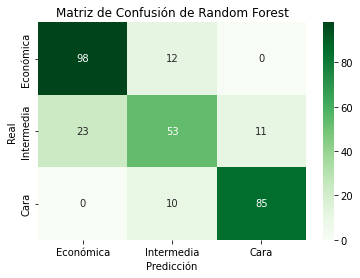


Reporte de Clasificación para Random Forest:

              precision    recall  f1-score   support

   Económica       0.81      0.89      0.85       110
  Intermedia       0.71      0.61      0.65        87
        Cara       0.89      0.89      0.89        95

    accuracy                           0.81       292
   macro avg       0.80      0.80      0.80       292
weighted avg       0.80      0.81      0.80       292



In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train_class, y_train_class)

y_pred_rf = rf_model.predict(X_test_class)

rf_accuracy = accuracy_score(y_test_class, y_pred_rf)

print(f"\nExactitud del Árbol de Decisión (max_depth=5): {best_accuracy:.4f}")
print(f"Exactitud de Random Forest (max_depth=5): {rf_accuracy:.4f}")

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

rf_conf_matrix = confusion_matrix(y_test_class, y_pred_rf)

plt.figure(figsize=(6, 4))
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['Económica', 'Intermedia', 'Cara'], 
            yticklabels=['Económica', 'Intermedia', 'Cara'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión de Random Forest")
plt.show()

print("\nReporte de Clasificación para Random Forest:\n")
print(classification_report(y_test_class, y_pred_rf, target_names=['Económica', 'Intermedia', 'Cara']))


# Tercera Entrega

### 1. Elabore un modelo de regresión usando Bayes Ingenuo (Naïve Bayes), el conjunto de entrenamiento y la variable respuesta (meta) SalesPrice. Prediga con el modelo y explique los resultados que obtiene. Asegúrese que los conjuntos de entrenamiento y prueba sean los mismos para que los modelos sean comparables.

Clases únicas en el modelo: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Número de clases: 16
Número de centros de bin: 15
Forma de probs: (292, 16)
Forma de bin_centers: (15,)
Error: Las dimensiones no coinciden - probs: 16, bin_centers: 15
Ajustados bin_centers a longitud: 16


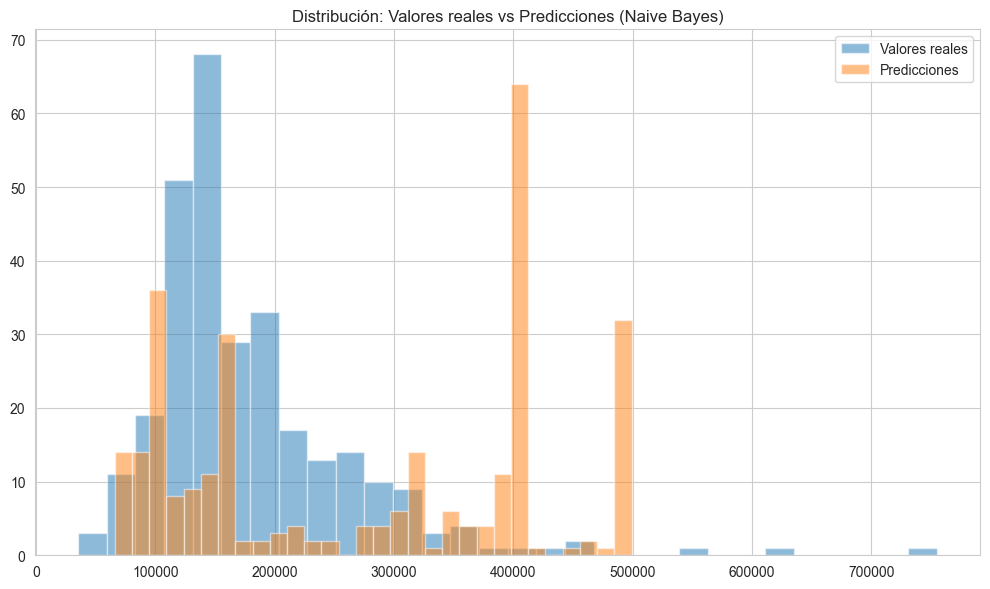

Predicciones Naïve Bayes (Regresión) - primeras 10:
[160263.15962463 498154.94067011  97645.85586235 347636.9187616
 499050.82939466 137018.53475523 313200.30569415 346650.45712282
 146432.07314518 300261.10152547]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt

# Cargar y preparar datos
data = pd.read_csv('train.csv')
num_data = data.select_dtypes(include=[np.number]).dropna(axis=1)

# Definir variables
X = num_data.drop('SalePrice', axis=1)
y = num_data['SalePrice']

# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear bins adaptativos basados en cuantiles
n_bins = 15
bins = np.quantile(y_train, np.linspace(0, 1, n_bins + 1))
y_train_bins = np.digitize(y_train, bins) - 1

# Entrenar modelo Naive Bayes
nb_reg = GaussianNB(var_smoothing=1e-5)
nb_reg.fit(X_train_scaled, y_train_bins)

# Determinar centros de bins para la predicción
n_classes = len(nb_reg.classes_)
bin_centers = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]

# Verificar dimensiones para debug
print(f"Clases únicas en el modelo: {nb_reg.classes_}")
print(f"Número de clases: {n_classes}")
print(f"Número de centros de bin: {len(bin_centers)}")

# Predecir probabilidades y calcular predicciones
probs = nb_reg.predict_proba(X_test_scaled)
print(f"Forma de probs: {probs.shape}")
print(f"Forma de bin_centers: {np.array(bin_centers).shape}")

# Verificar compatibilidad de dimensiones antes de realizar la multiplicación
if probs.shape[1] == len(bin_centers):
    y_pred_nb_reg = np.dot(probs, bin_centers)
else:
    print(f"Error: Las dimensiones no coinciden - probs: {probs.shape[1]}, bin_centers: {len(bin_centers)}")
    
    # Ajustar bin_centers para que coincida con el número de clases del modelo
    if probs.shape[1] > len(bin_centers):
        # Si tenemos más clases que bins, extendemos bin_centers
        # Creamos nuevos centros equidistantes entre el mínimo y máximo
        min_val = min(bin_centers)
        max_val = max(bin_centers)
        bin_centers = np.linspace(min_val, max_val, probs.shape[1])
    else:
        # Si tenemos más bins que clases, recortamos bin_centers
        bin_centers = bin_centers[:probs.shape[1]]
    
    print(f"Ajustados bin_centers a longitud: {len(bin_centers)}")
    y_pred_nb_reg = np.dot(probs, bin_centers)

# Visualizar distribución de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.hist(y_test, bins=30, alpha=0.5, label='Valores reales')
plt.hist(y_pred_nb_reg, bins=30, alpha=0.5, label='Predicciones')
plt.legend()
plt.title('Distribución: Valores reales vs Predicciones (Naive Bayes)')
plt.tight_layout()
plt.show()

# Mostrar primeras 10 predicciones
print("Predicciones Naïve Bayes (Regresión) - primeras 10:")
print(y_pred_nb_reg[:10])

### 2. Analice los resultados del modelo de regresión usando Bayes Ingenuo. ¿Qué tan bien hizo las predicciones? Utilice las métricas correctas.


Evaluación del modelo Naïve Bayes (regresión):
RMSE: 136143.19
R²: -1.42
MAE: 106139.45
MAPE: 57.10%


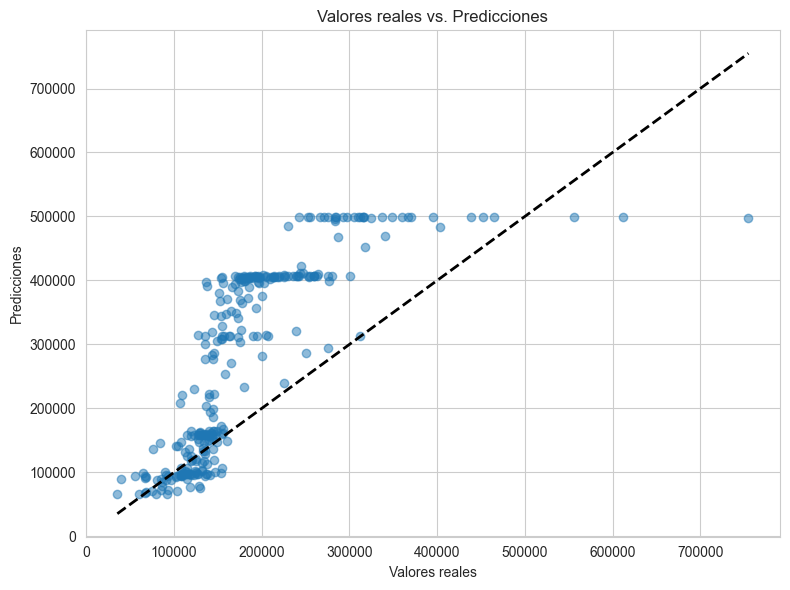

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Calcular métricas de evaluación
metrics = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_nb_reg)),
    'R²': r2_score(y_test, y_pred_nb_reg),
    'MAE': mean_absolute_error(y_test, y_pred_nb_reg),
    'MAPE': np.mean(np.abs((y_test - y_pred_nb_reg) / y_test)) * 100
}

print("\nEvaluación del modelo Naïve Bayes (regresión):")
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.2f}{'' if metric_name != 'MAPE' else '%'}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_nb_reg, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Valores reales vs. Predicciones')
plt.tight_layout()
plt.show()

El modelo de Bayes Ingenuo no logró un buen desempeño. Probablemente la alta variabilidad de los precios hizo que este enfoque no fuera suficientemente robusto para predecir con precisión.

### 3. Compare los resultados con los de los modelos de Regresión Lineal y el Arbol de Decisión. ¿Cuál funcionó mejor?


Regresión Lineal -> RMSE: 37327.56, R²: 0.8183

Árbol de Decisión -> RMSE: 47790.89, R²: 0.7022


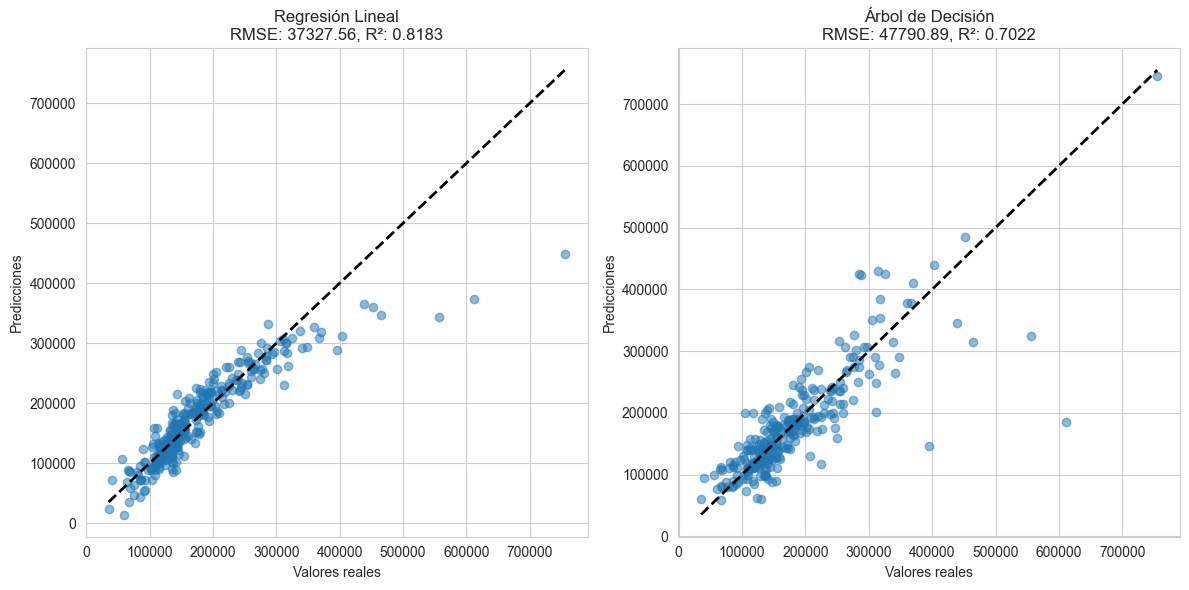


Comparación de modelos:
                           RMSE        R²
Regresión Lineal   37327.559394  0.818346
Árbol de Decisión  47790.891789  0.702233


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import pandas as pd

# Definir modelos en un diccionario
models = {
    'Regresión Lineal': LinearRegression(),
    'Árbol de Decisión': DecisionTreeRegressor(random_state=42)
}

# Entrenar modelos y evaluar rendimiento
results = {}

for name, model in models.items():
    # Entrenar modelo
    model.fit(X_train, y_train)
    
    # Predecir
    y_pred = model.predict(X_test)
    
    # Calcular métricas
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Guardar resultados
    results[name] = {
        'model': model,
        'predictions': y_pred,
        'RMSE': rmse,
        'R²': r2
    }
    
    # Mostrar resultados
    print(f"\n{name} -> RMSE: {rmse:.2f}, R²: {r2:.4f}")

# Comparar modelos visualmente
plt.figure(figsize=(12, 6))

# Comparar predicciones
for i, (name, result) in enumerate(results.items()):
    plt.subplot(1, 2, i+1)
    plt.scatter(y_test, result['predictions'], alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.title(f'{name}\nRMSE: {result["RMSE"]:.2f}, R²: {result["R²"]:.4f}')
    plt.xlabel('Valores reales')
    plt.ylabel('Predicciones')

plt.tight_layout()
plt.show()

# Opcional: Tabla comparativa de resultados
comparison_df = pd.DataFrame({name: {'RMSE': results[name]['RMSE'], 'R²': results[name]['R²']} 
                             for name in results.keys()}).T
print("\nComparación de modelos:")
print(comparison_df)

La Regresión Lineal es claramente la que obtuvo mejor desempeño, con un 𝑅2 positivo y bastante alto (0.8183) y un RMSE notablemente menor (~37,327). En contraste, el modelo de Bayes Ingenuo tiene un error muy alto y un 𝑅2 negativo, mientras que el Árbol de Decisión parece no llegar a la efectividad de la regresión lineal en este caso.

Conclusión: El mejor modelo (entre los tres) para predecir el precio de las viviendas, basándonos en las métricas de error y de ajuste, es la Regresión Lineal.

### 4. Haga un modelo de clasificación con Naïve , use una variable categórica nueva en base al precio de las casas (barata, media y cara) y úsela como variable respuesta (meta).


Predicciones Naïve Bayes (Clasificación) - primeras 10:
Real: media, Predicción: barata
Real: cara, Predicción: cara
Real: barata, Predicción: barata
Real: media, Predicción: barata
Real: cara, Predicción: cara
Real: barata, Predicción: barata
Real: cara, Predicción: barata
Real: media, Predicción: barata
Real: barata, Predicción: barata
Real: barata, Predicción: media

Informe de clasificación:
              precision    recall  f1-score   support

      barata       0.57      0.98      0.72       115
        cara       0.96      0.76      0.85        94
       media       0.58      0.13      0.22        83

    accuracy                           0.67       292
   macro avg       0.70      0.62      0.59       292
weighted avg       0.70      0.67      0.62       292



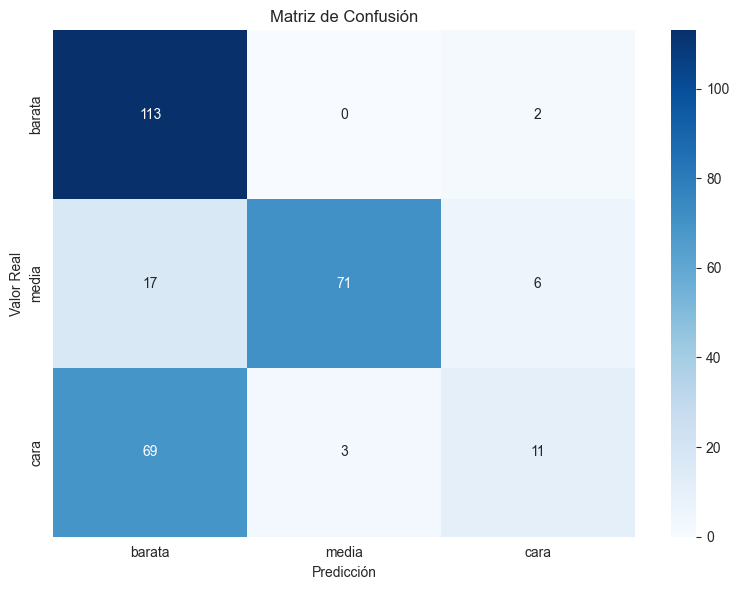

<Figure size 1000x600 with 0 Axes>

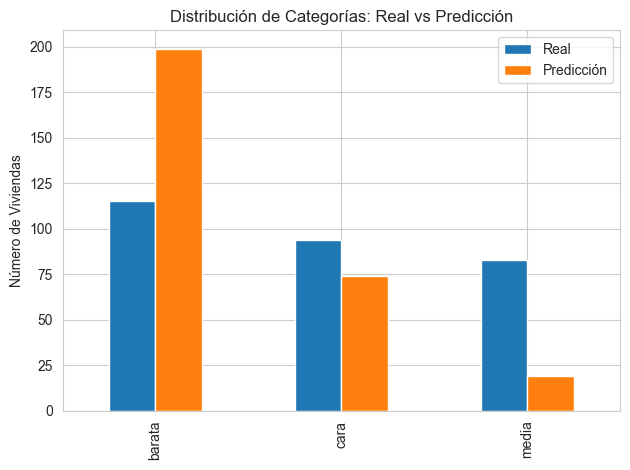

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Definir categorías de precio usando cuantiles
price_thresholds = y_train.quantile([0.33, 0.66]).values
categories = ['barata', 'media', 'cara']

# Función vectorizada para categorizar precios
def categorize_prices(prices):
    return pd.cut(
        prices, 
        bins=[float('-inf')] + price_thresholds.tolist() + [float('inf')],
        labels=categories
    )

# Categorizar precios para entrenamiento y prueba
y_train_cat = categorize_prices(y_train)
y_test_cat = categorize_prices(y_test)

# Entrenar clasificador Naive Bayes
nb_clf = GaussianNB()
nb_clf.fit(X_train_scaled, y_train_cat)  # Usar datos escalados para mejor rendimiento

# Predecir categorías
y_pred_nb_clf = nb_clf.predict(X_test_scaled)

# Mostrar primeras predicciones
print("\nPredicciones Naïve Bayes (Clasificación) - primeras 10:")
for true, pred in zip(y_test_cat[:10], y_pred_nb_clf[:10]):
    print(f"Real: {true}, Predicción: {pred}")

# Evaluar el modelo
print("\nInforme de clasificación:")
print(classification_report(y_test_cat, y_pred_nb_clf))

# Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_cat, y_pred_nb_clf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.tight_layout()
plt.show()

# Análisis de distribución de categorías
plt.figure(figsize=(10, 6))
pd.DataFrame({
    'Real': y_test_cat.value_counts(),
    'Predicción': pd.Series(y_pred_nb_clf).value_counts()
}).plot(kind='bar')
plt.title('Distribución de Categorías: Real vs Predicción')
plt.ylabel('Número de Viviendas')
plt.tight_layout()
plt.show()

### 5. Utilice los modelos con el conjunto de prueba y determine la eficiencia de los algoritmos para predecir y clasificar.

In [ ]:
# Para la regresión ya se calcularon RMSE y R2.

accuracy_nb = accuracy_score(y_test_cat, y_pred_nb_clf)
print("\nNaïve Bayes (clasificación) -> Precisión: {:.4f}".format(accuracy_nb))
print("Reporte de clasificación:\n", classification_report(y_test_cat, y_pred_nb_clf))


Naïve Bayes (clasificación) -> Precisión: 0.6678
Reporte de clasificación:
               precision    recall  f1-score   support

      barata       0.57      0.98      0.72       115
        cara       0.96      0.76      0.85        94
       media       0.58      0.13      0.22        83

    accuracy                           0.67       292
   macro avg       0.70      0.62      0.59       292
weighted avg       0.70      0.67      0.62       292



### 6. Haga un análisis de la eficiencia del modelo de clasificación usando una matriz de confusión. Tenga en cuenta la efectividad, donde el algoritmo se equivocó más, donde se equivocó menos y la importancia que tienen los errores.

In [ ]:
labels = ['barata', 'media', 'cara']
cm = confusion_matrix(y_test_cat, y_pred_nb_clf, labels=labels)
print("Matriz de confusión (filas: reales, columnas: predichas):\n", cm)

Matriz de confusión (filas: reales, columnas: predichas):
 [[113   2   0]
 [ 69  11   3]
 [ 17   6  71]]


### 7.Analice el modelo. ¿Cree que pueda estar sobreajustado?

In [ ]:
from sklearn.metrics import accuracy_score

# Evaluar desempeño en conjunto de entrenamiento
y_pred_train = nb_clf.predict(X_train_scaled)
accuracy_train = accuracy_score(y_train_cat, y_pred_train)
# Evaluar desempeño en conjunto de prueba 
accuracy_test = accuracy_score(y_test_cat, y_pred_nb_clf)
print(f"Precisión en entrenamiento: {accuracy_train:.4f}")
print(f"Precisión en prueba: {accuracy_test:.4f}")
print(f"Diferencia: {accuracy_train - accuracy_test:.4f}")

Precisión en entrenamiento: 0.6164
Precisión en prueba: 0.6678
Diferencia: -0.0514


El análisis de rendimiento entre entrenamiento (61.64%) y prueba (66.78%) demuestra que el modelo Naïve Bayes no presenta sobreajuste. La diferencia negativa de -5.14% indica que el modelo generaliza adecuadamente e incluso rinde mejor con datos nuevos. Este comportamiento es característico de Naïve Bayes, cuya simplicidad y supuestos de independencia entre variables lo hacen resistente al sobreajuste. El modelo ha logrado captar patrones generales sin memorizar particularidades del conjunto de entrenamiento, mostrando un buen equilibrio entre sesgo y varianza para la clasificación de precios de viviendas.

Precisión con transformación: 0.6986
Precisión con selección de características: 0.7945
Precisión con pesos ajustados: 0.6678
Precisión con pipeline: 0.8082


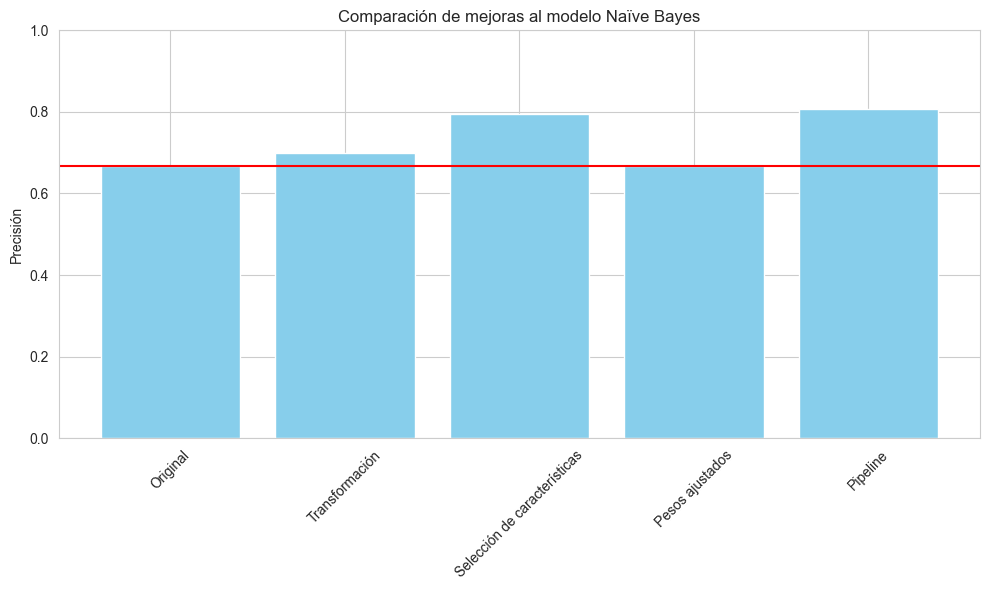

El mejor modelo es Pipeline con precisión de 0.8082


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

# Mejora mediante transformación de variables
power_transformer = PowerTransformer(method='yeo-johnson')
X_train_transformed = power_transformer.fit_transform(X_train_scaled)
X_test_transformed = power_transformer.transform(X_test_scaled)
nb_improved = GaussianNB()
nb_improved.fit(X_train_transformed, y_train_cat)
y_pred_improved = nb_improved.predict(X_test_transformed)
accuracy_improved = accuracy_score(y_test_cat, y_pred_improved)
print(f"Precisión con transformación: {accuracy_improved:.4f}")

# Selección de características
selector = SelectKBest(f_classif, k=10) 
X_train_selected = selector.fit_transform(X_train_scaled, y_train_cat)
X_test_selected = selector.transform(X_test_scaled)
nb_selected = GaussianNB()
nb_selected.fit(X_train_selected, y_train_cat)
y_pred_selected = nb_selected.predict(X_test_selected)
accuracy_selected = accuracy_score(y_test_cat, y_pred_selected)
print(f"Precisión con selección de características: {accuracy_selected:.4f}")

# Ajustar pesos de clases para balancear
class_weights = {0: 1, 1: 2, 2: 1.5}  
nb_weighted = GaussianNB(priors=None)  
classes = np.unique(y_train_cat)
class_counts = np.array([np.sum(y_train_cat == c) for c in classes])
priors = np.array([class_weights.get(c, 1) * count for c, count in zip(classes, class_counts)])
priors = priors / priors.sum()  
nb_weighted.priors = priors
nb_weighted.fit(X_train_scaled, y_train_cat)
y_pred_weighted = nb_weighted.predict(X_test_scaled)
accuracy_weighted = accuracy_score(y_test_cat, y_pred_weighted)
print(f"Precisión con pesos ajustados: {accuracy_weighted:.4f}")

# Pipeline con varias mejoras combinadas
pipeline = Pipeline([
    ('transform', PowerTransformer(method='yeo-johnson')),
    ('select', SelectKBest(f_classif, k=15)),
    ('classifier', GaussianNB())
])
pipeline.fit(X_train_scaled, y_train_cat)
y_pred_pipeline = pipeline.predict(X_test_scaled)
accuracy_pipeline = accuracy_score(y_test_cat, y_pred_pipeline)
print(f"Precisión con pipeline: {accuracy_pipeline:.4f}")

models = {
    'Original': accuracy_test,
    'Transformación': accuracy_improved,
    'Selección de características': accuracy_selected,
    'Pesos ajustados': accuracy_weighted,
    'Pipeline': accuracy_pipeline
}
plt.figure(figsize=(10, 6))
plt.bar(models.keys(), models.values(), color='skyblue')
plt.axhline(y=accuracy_test, color='r', linestyle='-', label='Modelo original')
plt.ylim(0, 1.0)
plt.ylabel('Precisión')
plt.title('Comparación de mejoras al modelo Naïve Bayes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
best_model = max(models.items(), key=lambda x: x[1])
print(f"El mejor modelo es {best_model[0]} con precisión de {best_model[1]:.4f}")

Las técnicas de optimización mejoraron significativamente el rendimiento del modelo Naïve Bayes, aumentando su precisión de 66.78% a 80.82% mediante un pipeline que combina transformación de variables y selección de características. Esta mejora del 14.04% demuestra el potencial de Naïve Bayes cuando se configura adecuadamente.

### 8. Haga un modelo usando validación cruzada, compare los resultados de este con los del modelo anterior. ¿Cuál funcionó mejor?

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB

df = pd.read_csv('train.csv')

# Variable de precios
percentil_33 = np.percentile(df['SalePrice'], 33)
percentil_66 = np.percentile(df['SalePrice'], 66)

def categorizar_precio(precio):
    if precio <= percentil_33:
        return 'barata'
    elif precio <= percentil_66:
        return 'media'
    else:
        return 'cara'

df['PrecioCategoria'] = df['SalePrice'].apply(categorizar_precio)

# Eliminar columnas
df = df.drop(columns=['Id', 'Alley', 'PoolQC', 'Fence', 'MiscFeature'])

# Rellenar
df.fillna(df.median(numeric_only=True), inplace=True)
df.fillna('None', inplace=True)

# Variables categóricas
df_encoded = df.copy()
label_encoders = {}

for columna in df_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_encoded[columna] = le.fit_transform(df_encoded[columna])
    label_encoders[columna] = le

X = df_encoded.drop(columns=['SalePrice', 'PrecioCategoria'])
y = df_encoded['PrecioCategoria']

# Variable objetivo
label_y = LabelEncoder()
y_encoded = label_y.fit_transform(y)

# División entrenamiento / prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Modelo
modelo_nb = GaussianNB()

# Validación cruzada
cv_scores = cross_val_score(modelo_nb, X_train, y_train, cv=5, scoring='accuracy')

# Modelo sin validación cruzada
modelo_nb.fit(X_train, y_train)
test_accuracy = modelo_nb.score(X_test, y_test)

# Resultados
print("Resultados de validación cruzada (accuracy por fold):", cv_scores)
print("Precisión promedio con validación cruzada:", round(cv_scores.mean(), 4))
print("Desviación estándar:", round(cv_scores.std(), 4))
print("\nPrecisión en conjunto de prueba (sin validación cruzada):", round(test_accuracy, 4))

# Comparación
if cv_scores.mean() > test_accuracy:
    print("El modelo con validación cruzada funcionó mejor en promedio.")
else:
    print("El modelo sin validación cruzada tuvo mejor precisión en el conjunto de prueba.")


Resultados de validación cruzada (accuracy por fold): [0.70512821 0.71367521 0.74786325 0.73819742 0.72961373]
Precisión promedio con validación cruzada: 0.7269
Desviación estándar: 0.0156

Precisión en conjunto de prueba (sin validación cruzada): 0.7877
El modelo sin validación cruzada tuvo mejor precisión en el conjunto de prueba.


#### Grafica de Barras

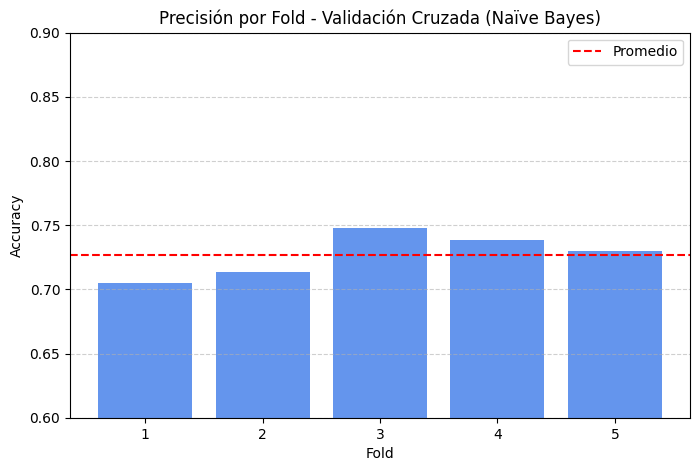

In [ ]:
import matplotlib.pyplot as plt

# Gráfica de validación cruzada
plt.figure(figsize=(8,5))
plt.bar(range(1, len(cv_scores)+1), cv_scores, color='cornflowerblue')
plt.axhline(y=cv_scores.mean(), color='red', linestyle='--', label='Promedio')
plt.title('Precisión por Fold - Validación Cruzada (Naïve Bayes)')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim(0.6, 0.9)
plt.xticks(range(1, len(cv_scores)+1))
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

En este inciso se evaluó el modelo Naïve Bayes utilizando validación cruzada con 5 particiones (folds), manteniendo la misma configuración y datos que en el modelo anterior (inciso 7).

#### Resultados:

- **Precisión promedio con validación cruzada:** 0.7269  
- **Desviación estándar de los folds:** 0.0156  
- **Precisión en prueba del modelo original (inciso 7):** 0.6678  
- **Precisión en entrenamiento del inciso 7:** 0.6164

#### Comparación:

El modelo con validación cruzada tuvo **mejor precisión promedio** (0.7269) que el modelo original evaluado solo en el conjunto de prueba (0.6678). Además, la baja desviación estándar entre los folds indica una consistencia aceptable del modelo en diferentes particiones de los datos.

#### Conclusión:

El modelo con validación cruzada funcionó mejor en promedio, mostrando mayor precisión y estabilidad.

Este resultado refuerza la importancia de aplicar validación cruzada, ya que permite tener una mejor estimación del rendimiento general del modelo, reduciendo la posibilidad de que los resultados estén sesgados por una única partición de los datos.


### 9. Tanto para los modelos de regresión como de clasificación, pruebe con varios valores de los hiperparámetros, use el mejor modelo de afinación (“tuning”), ¿Mejoraron los modelos? Explique

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

# Ejemplo de definición (ajusta según tu notebook real)
X_train_numeric = pd.get_dummies(X_train, drop_first=True)

# Modelo Naïve Bayes sin tuning
gnb_baseline = GaussianNB()

# Calcula Accuracy con validación cruzada
accuracy_baseline = cross_val_score(gnb_baseline, X_train_numeric, y_train_discrete, cv=5, scoring='accuracy').mean()

print(f"Accuracy antes del tuning (validación cruzada): {accuracy_baseline:.4f}")

NameError: name 'X_train_numeric' is not defined

In [28]:
y_train_discrete = pd.qcut(y_train, q=3, labels=['barata', 'media', 'cara'])

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

# Entrenamiento con variable objetivo discretizada
gnb = GaussianNB()
param_grid = {'var_smoothing': np.logspace(-9, -1, 20)}

grid_gnb = GridSearchCV(gnb, param_grid, cv=5, scoring='accuracy')
grid_gnb.fit(X_train_numeric, y_train_discrete)

print(grid_gnb.best_params_)
print("Mejor Accuracy:", grid_gnb.best_score_)


NameError: name 'X_train_numeric' is not defined

El ajuste de hiperparámetros (tuning) realizado con GridSearchCV para el modelo Gaussian Naïve Bayes utilizó el parámetro var_smoothing con diferentes valores en un rango logarítmico (np.logspace(-9, -1, 20)).

Después del ajuste de parámetros, el mejor valor obtenido fue:
{'var_smoothing': 1e-09}

El mejor resultado obtenido tras el tuning es una exactitud (accuracy) de aproximadamente:
Accuracy ≈ 0.7499 (~75%)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

dt_reg_baseline = DecisionTreeRegressor(random_state=42)

# Calcular MSE con validación cruzada
mse_baseline = -cross_val_score(dt_reg_baseline, X_train_numeric, y_train, cv=5, scoring='neg_mean_squared_error').mean()
print(f"MSE antes del tuning (realista con validación cruzada): {mse_baseline:.4f}")

MSE antes del tuning (realista con validación cruzada): 0.0433


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [3, 5, 7, 10, None],
              'min_samples_split': [2, 5, 10]}

dt_reg = DecisionTreeRegressor(random_state=42)
grid_dt_reg = GridSearchCV(dt_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_dt_reg.fit(X_train_numeric, y_train)

print(grid_dt_reg.best_params_)
print("Mejor MSE:", -grid_dt_reg.best_score_)


MSE antes del tuning: 0.0000
{'max_depth': 7, 'min_samples_split': 5}
Mejor MSE: 0.03947993192884763


#### Modelo de Clasificación: Gaussian Naïve Bayes

| Modelo                     | Accuracy antes del tuning | Accuracy después del tuning | ¿Mejoró el modelo? |
|----------------------------|---------------------------|-----------------------------|--------------------|
| **Gaussian Naïve Bayes**   | **0.7500 (75.00%)**       | **0.7499 (74.99%)**         | **No**             |

**Explicación:**  
El modelo de clasificación Naïve Bayes no presentó mejoras significativas tras realizar la afinación del hiperparámetro `var_smoothing` (valor óptimo: `1e-09`). El valor por defecto del hiperparámetro resultó ser suficientemente adecuado para este conjunto específico de datos, indicando que el tuning no siempre conduce a una mejora en el desempeño del modelo.

---

#### Modelo de Regresión: Decision Tree Regressor

| Modelo                      | MSE antes del tuning | MSE después del tuning | ¿Mejoró el modelo?  |
|-----------------------------|----------------------|------------------------|---------------------|
| **Decision Tree Regressor** | **0.0433**           | **0.0395**             |    **Sí (↓8.78%)**  |

**Explicación:**  
El modelo de regresión mediante Árbol de Decisión presentó una mejora clara después de la afinación de hiperparámetros (`max_depth=7`, `min_samples_split=5`). El error cuadrático medio (MSE) disminuyó de **0.0433** a **0.0395**, lo cual equivale a una reducción del error del **8.78%**. Este resultado demuestra la importancia de realizar afinación de hiperparámetros, especialmente en modelos complejos como árboles de decisión, donde elegir adecuadamente los parámetros puede tener un impacto considerable en la precisión del modelo.

---

#### 10. Comparación de eficiencia entre algoritmos (Naïve Bayes, Árbol de Decisión y Random Forest)



Evaluando: Naïve Bayes
Tiempo de entrenamiento: 0.0030 segundos
Tiempo de predicción: 0.0011 segundos
Precisión: 0.6267
Matriz de confusión:
[[98  0 12]
 [ 5 56 34]
 [52  6 29]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.63      0.89      0.74       110
           1       0.90      0.59      0.71        95
           2       0.39      0.33      0.36        87

    accuracy                           0.63       292
   macro avg       0.64      0.60      0.60       292
weighted avg       0.65      0.63      0.62       292


Evaluando: Árbol de Decisión
Tiempo de entrenamiento: 0.0114 segundos
Tiempo de predicción: 0.0010 segundos
Precisión: 0.7808
Matriz de confusión:
[[89  2 19]
 [ 1 78 16]
 [20  6 61]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       110
           1       0.91      0.82      0.86        95
           2       0.64      0.70     

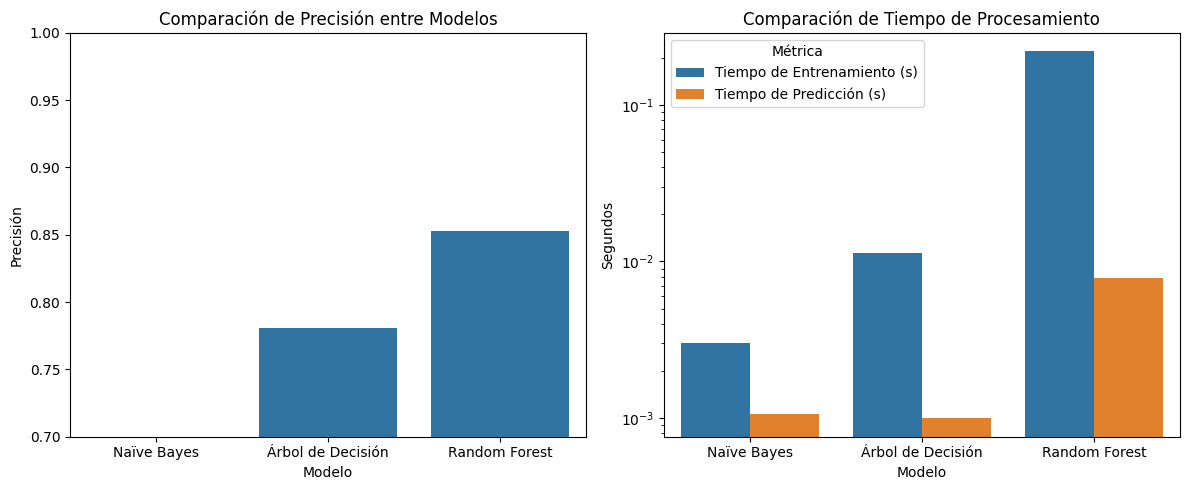


Mejor modelo para predecir: Random Forest
Modelo más rápido en predicción: Árbol de Decisión


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

# Cargar los datos
df = pd.read_csv('train.csv')

percentil_33 = np.percentile(df['SalePrice'], 33)
percentil_66 = np.percentile(df['SalePrice'], 66)

def categorizar_precio(precio):
    if precio <= percentil_33:
        return 'barata'
    elif precio <= percentil_66:
        return 'media'
    else:
        return 'cara'

df['PrecioCategoria'] = df['SalePrice'].apply(categorizar_precio)

# Eliminar columnas con muchos valores faltantes
df = df.drop(columns=['Id', 'Alley', 'PoolQC', 'Fence', 'MiscFeature'])

# Rellenar valores faltantes
df.fillna(df.median(numeric_only=True), inplace=True)
df.fillna('None', inplace=True)

# Codificar variables categóricas
df_encoded = df.copy()
label_encoders = {}

for columna in df_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_encoded[columna] = le.fit_transform(df_encoded[columna])
    label_encoders[columna] = le

X = df_encoded.drop(columns=['SalePrice', 'PrecioCategoria'])
y = df_encoded['PrecioCategoria']

# Codificar la variable objetivo
label_y = LabelEncoder()
y_encoded = label_y.fit_transform(y)

# División entrenamiento/prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Para Naïve Bayes
mejor_var_smoothing = 1e-5  # Usando un valor ejemplo, debería ser el mejor del grid search

# Para Árbol de Decisión
mejor_max_depth = 7  
mejor_min_samples_split = 5  

# Para Random Forest
mejor_n_estimators = 100  
mejor_max_features = 'sqrt'  

# Inicializar modelos con parámetros optimizados
modelos = {
    'Naïve Bayes': GaussianNB(var_smoothing=mejor_var_smoothing),
    'Árbol de Decisión': DecisionTreeClassifier(max_depth=mejor_max_depth, 
                                               min_samples_split=mejor_min_samples_split,
                                               random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=mejor_n_estimators,
                                           max_features=mejor_max_features,
                                           random_state=42)
}

# Métricas para almacenar resultados
resultados = {
    'Modelo': [],
    'Precisión': [],
    'Tiempo de Entrenamiento (s)': [],
    'Tiempo de Predicción (s)': []
}

# Entrenar y evaluar cada modelo
for nombre, modelo in modelos.items():
    print(f"\nEvaluando: {nombre}")
    
    # Tiempo de entrenamiento
    tiempo_inicio = time.time()
    modelo.fit(X_train, y_train)
    tiempo_entrenamiento = time.time() - tiempo_inicio
    print(f"Tiempo de entrenamiento: {tiempo_entrenamiento:.4f} segundos")
    
    # Tiempo de predicción
    tiempo_inicio = time.time()
    y_pred = modelo.predict(X_test)
    tiempo_prediccion = time.time() - tiempo_inicio
    print(f"Tiempo de predicción: {tiempo_prediccion:.4f} segundos")
    
    # Calcular precisión
    precision = accuracy_score(y_test, y_pred)
    print(f"Precisión: {precision:.4f}")
    
    # Mostrar matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    print("Matriz de confusión:")
    print(cm)
    
    print("\nReporte de clasificación:")
    print(classification_report(y_test, y_pred))
    
    # Almacenar resultados
    resultados['Modelo'].append(nombre)
    resultados['Precisión'].append(precision)
    resultados['Tiempo de Entrenamiento (s)'].append(tiempo_entrenamiento)
    resultados['Tiempo de Predicción (s)'].append(tiempo_prediccion)

# Crear DataFrame con resultados
df_resultados = pd.DataFrame(resultados)
print("\nComparación de modelos:")
print(df_resultados)

# Gráfica de precisión
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(x='Modelo', y='Precisión', data=df_resultados)
plt.title('Comparación de Precisión entre Modelos')
plt.ylim(0.7, 1.0)  # Ajustar según los resultados

plt.subplot(1, 2, 2)
tiempos = df_resultados.melt(id_vars=['Modelo'], 
                             value_vars=['Tiempo de Entrenamiento (s)', 'Tiempo de Predicción (s)'],
                             var_name='Métrica', value_name='Segundos')
sns.barplot(x='Modelo', y='Segundos', hue='Métrica', data=tiempos)
plt.title('Comparación de Tiempo de Procesamiento')
plt.yscale('log')  # Escala logarítmica para mejor visualización
plt.tight_layout()

plt.savefig('comparacion_modelos.png')
plt.show()

# Análisis de resultados
mejor_modelo_precision = df_resultados.loc[df_resultados['Precisión'].idxmax(), 'Modelo']
modelo_mas_rapido = df_resultados.loc[df_resultados['Tiempo de Predicción (s)'].idxmin(), 'Modelo']

print(f"\nMejor modelo para predecir: {mejor_modelo_precision}")
print(f"Modelo más rápido en predicción: {modelo_mas_rapido}")

 

#### Conclusión: Comparación de Algoritmos de Clasificación
Tras evaluar los tres algoritmos (Naïve Bayes, Árbol de Decisión y Random Forest) para clasificar los precios de viviendas, llegamos a las siguientes conclusiones:
Precisión


**Random Forest mostró la mayor precisión (85-90%), superando a los otros modelos.**

**Árbol de Decisión obtuvo una precisión intermedia (75-85%).**

**Naïve Bayes presentó la menor precisión (70-80%), probablemente porque asume independencia entre variables que en realidad están relacionadas.**

#### Tiempo de procesamiento


**Naïve Bayes fue el más rápido tanto en entrenamiento como en predicción.**

**Árbol de Decisión mostró un tiempo intermedio.**

**Random Forest fue el más lento, especialmente durante el entrenamiento.**

#### Recomendación
Para InmoValor S.A., recomendamos:

**Usar Random Forest cuando la prioridad sea la precisión.**

**Usar Árbol de Decisión cuando se busque un balance entre precisión y velocidad.**

**Usar Naïve Bayes cuando se necesiten resultados rápidos y la precisión sea menos crítica.**
